###Vipunen Dashboard###
is a Streamlit-based data exploration and visualization app that connects to Finland’s official Vipunen educational statistics API. It allows users to interactively query, filter, and visualize higher education data across Finnish universities.



### Import Libraries




In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import ipywidgets as widgets
from IPython.display import display, clear_output

### Understanding the `VipunenAPI` Class

This class is a simple wrapper for fetching data from the [Vipunen Open Data API](https://vipunen.fi/). It helps you send API requests, handle large datasets using pagination, and return clean pandas DataFrames for analysis.

---

Class Overview

```python
class VipunenAPI:
    def __init__(self, caller_id="your_organization_id"):
        ...
        
    def fetch_data(self, dataset, filters=None, limit=5000):
        ...

### Explanation of the functions 

__init__ Method

- Called when you create a new VipunenAPI object.
- self.base_url: Base URL for API access.
- self.headers: HTTP headers for the request, including your Caller-Id.

fetch_data Method

- Purpose: Download data from a specific Vipunen dataset, optionally filtered and paginated.
- dataset: The dataset name (e.g. "opiskelijat_ja_tutkinnot").
- filters: Optional string to filter data (e.g. "tilastovuosi==2020").
- limit: How many rows to request at once (default is 5000).

Error Handling

- The code includes try/except blocks around requests to handle network/API errors gracefully.
- If any call fails, it prints the error message instead of crashing the program.


The Vipunen API class is a reusable, modular way to:

- Authenticate and send requests to the Vipunen API
- Handle large datasets using pagination
- Return clean pandas DataFrames
- Make filtering easy using query strings

In [3]:
# VipunenAPI class 
class VipunenAPI:
    def __init__(self, caller_id="your_organization_id"):
        self.base_url = "https://api.vipunen.fi/api/resources"
        self.headers = {
            "Content-Type": "application/json",
            "Accept": "application/json",
            "Caller-Id": caller_id
        }

    def fetch_data(self, dataset, filters=None, limit=5000):
        data = []
        offset = 0
        filter_query = f"&filter={filters}" if filters else ""
        count_url = f"{self.base_url}/{dataset}/data/count?{filter_query}"

        try:
            response = requests.get(count_url, headers=self.headers)
            if response.status_code == 200:
                total_records = response.json()
            else:
                raise ValueError(f"Error {response.status_code}: {response.text}")
        except Exception as e:
            print(f"Error fetching data count: {e}")
            return pd.DataFrame()

        # Fetch data in pages
        while offset < total_records:
            url = f"{self.base_url}/{dataset}/data?limit={limit}&offset={offset}{filter_query}"
            try:
                response = requests.get(url, headers=self.headers)
                if response.status_code == 200:
                    data.extend(response.json())
                else:
                    print(f"Pagination Error {response.status_code}: {response.text}")
                offset += limit
            except Exception as e:
                print(f"Error fetching data: {e}")
                break

        return pd.DataFrame(data)

In [4]:
# datasets = [
#     "erilliset_opinto_oikeudet", "opiskelijat_ja_tutkinnot", "lukio_opiskelijat_vuosi_tutkinto",
#     "yo_talous2", "avoin_amk", "amk_talous", "lukio_opiskelijat_kuukausi_maakunta", "suorittanut55",
#     "harjoittelukoulut", "tavoiteajassa_tutkinnon_suorittaneet", "henkilosto", "amm_perusrahoituksen_kohdennukset",
#     "taydennyskoulutukset", "opinnaytetyot", "amm_rahoitus_opiskelijavuodet", "julkaisut", "avoin_yliopisto",
#     "suoritteet", "amk_opintopisteet_kuukausi", "opiskelijat_ja_tutkinnot", "toimipisteet",
#     "amm_opiskelijat_ja_tutkinnot_kuukausi_maakunta", "amm_rahoitusperusteet_ja_myonnetty_rahoitus",
#     "korkeakoulutus_kv_liikkuvuus", "yo_opintopisteet", "amk_opintopisteet", "koulutusluokitus", "yo_talous",
#     "amk_talous2", "ytl_arvosanat", "korkeakoulutus_hakeneet_ja_paikan_vastaanottaneet", "alayksikkokoodisto",
#     "koulutuksenkustannukset", "toimitilat", "muu_henkilosto_amk", "yamk_tutkinnot",
#     "amm_opiskelijat_ja_tutkinnot_vuosi_tutkinto", "yo_opintopisteet_kuukausi"
# ]

# universities = [
#     "Aalto-yliopisto", "Helsingin yliopisto", "Itä-Suomen yliopisto",
#     "Jyväskylän yliopisto", "Lapin yliopisto", "Lappeenrannan-Lahden teknillinen yliopisto LUT",
#     "Oulun yliopisto", "Svenska handelshögskolan", "Turun yliopisto", "Vaasan yliopisto", "Åbo Akademi"
# ]

In [5]:
# Predefined settings
dataset = "opiskelijat_ja_tutkinnot"
years = [2019, 2020, 2021]
university = "Åbo Akademi"

# Initialize API
api = VipunenAPI()

### Looping Over Years and Universities

We’ll loop through each year and each university, fetch the data using the API, and filter it down to rows that match the current university.

We also clean the text (e.g., lowercase, strip whitespace) for consistent matching.

Summary

This loop does the following:
- Filters data by year (`tilastovuosi`)
- Finds the column that contains university names
- Normalizes text for safe comparison
- Loops through each university and prints

In [6]:
# Loop through each year and display data
for year in years:
    print(f"\n=== Dataset: {dataset} | Year: {year} | University: {university} ===")

    try:
        filters = f"tilastovuosi=={year}"
        df = api.fetch_data(dataset, filters=filters)

        if not df.empty:
            df["tilastovuosi"] = year

            # Try filtering by university
            filter_columns = ["korkeakoulu", "yliopisto", "koulutuksenJarjestaja"]
            matched_column = next((col for col in filter_columns if col in df.columns), None)

            if matched_column:
                df[matched_column] = df[matched_column].str.strip().str.lower()
                filtered_df = df[df[matched_column] == university.lower()]
            else:
                filtered_df = df

            if not filtered_df.empty:
                display(filtered_df.head(20))  # show first 20 rows
            else:
                print("No matching records for university.")
        else:
            print("No data returned for this year.")

    except Exception as e:
        print(f"Error fetching/displaying data for {year}: {e}")


=== Dataset: opiskelijat_ja_tutkinnot | Year: 2019 | University: Åbo Akademi ===


,tilastovuosi,aineistotyyppi,sektori,korkeakoulu,koulutus,sukupuoli,tutkinnot,opiskelijat,opiskelijatfte,uudetOpiskelijat,...,rahoitusmallialaAmk2021-2024,rahoitusmallialaYo2017-2020,rahoitusmallialaYo2021-2024,rahoituslahde,kirjoillaoloTammi,kirjoillaoloSyys,koodiSektori,koodiKorkeakoulu,koodiKoulutus,tietojoukkoPaivitettyPvm
15,2019,Lopullinen,Yliopistokoulutus,åbo akademi,"Valtiot. maist., muu tai tuntematon pääaineryhmä",nainen,0,2,2.0,2,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Yhteiskuntatieteet ja palvelualat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Opiskelija ei ollut kirjoilla 1.1. - 31.7,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,733199,2025-04-14
16,2019,Lopullinen,Yliopistokoulutus,åbo akademi,"Tekn. toht., kemian tekniikka",mies,6,0,0.0,0,...,"Luonnontieteet, tietojenkäsittely ja tietoliik...",Tietojenkäsittely ja tietoliikenne sekä teknii...,Tietojenkäsittely ja tietoliikenne sekä teknii...,Perusrahoitus,Tuntematon,Tuntematon,5,01903,855401,2025-04-14
42,2019,Lopullinen,Yliopistokoulutus,åbo akademi,"Kasvatust. kand. (alempi), luokanopettaja (ei ...",nainen,0,52,50.0,49,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Kasvatusalat,Kasvatusalat,Perusrahoitus,Opiskelija ei ollut kirjoilla 1.1. - 31.7,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,612102,2025-04-14
88,2019,Lopullinen,Yliopistokoulutus,åbo akademi,"Kauppat. kand. (alempi), yhteiskuntatieteet",mies,0,30,27.0,0,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Yhteiskuntatieteet ja palvelualat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,632105,2025-04-14
89,2019,Lopullinen,Yliopistokoulutus,åbo akademi,"Kauppat. kand. (alempi), liiketaloustieteet",mies,0,128,106.0,0,...,"Liiketalous, hallinto ja oikeustieteet ja palv...","Liiketalous, hallinto ja oikeustieteet","Liiketalous, hallinto- ja oikeustieteet",Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,632101,2025-04-14
95,2019,Lopullinen,Yliopistokoulutus,åbo akademi,"Valtiot. kand. (alempi), politiikkatieteet",nainen,0,74,64.0,0,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Yhteiskuntatieteet ja palvelualat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,633101,2025-04-14
143,2019,Lopullinen,Yliopistokoulutus,åbo akademi,"Hum. kand., saksan kieli",nainen,0,1,0.0,0,...,"Humanistiset alat, lääketieteet ja terveys- ja...",Taiteet ja kulttuurialat sekä humanistiset alat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Poissa (opiskelija oli kirjoilla oppilaitokses...,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,623104,2025-04-14
144,2019,Lopullinen,Yliopistokoulutus,åbo akademi,"Valtiot. maist., politiikkatieteet",mies,0,1,NaN,1,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Yhteiskuntatieteet ja palvelualat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Opiskelija ei ollut kirjoilla 1.1. - 31.7,Poissa (=opiskelija on kirjoilla oppilaitokses...,5,01903,733101,2025-04-14
155,2019,Lopullinen,Yliopistokoulutus,åbo akademi,Teologian tohtori,nainen,1,0,0.0,0,...,"Humanistiset alat, lääketieteet ja terveys- ja...",Taiteet ja kulttuurialat sekä humanistiset alat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Tuntematon,Tuntematon,5,01903,827101,2025-04-14
178,2019,Lopullinen,Yliopistokoulutus,åbo akademi,"Dipl.ins., tietotekniikka",mies,0,4,NaN,0,...,"Luonnontieteet, tietojenkäsittely ja tietoliik...",Tietojenkäsittely ja tietoliikenne sekä teknii...,Tietojenkäsittely ja tietoliikenne sekä teknii...,Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Poissa (=opiskelija on kirjoilla oppilaitokses...,5,01903,751301,2025-04-14



=== Dataset: opiskelijat_ja_tutkinnot | Year: 2020 | University: Åbo Akademi ===


,tilastovuosi,aineistotyyppi,sektori,korkeakoulu,koulutus,sukupuoli,tutkinnot,opiskelijat,opiskelijatfte,uudetOpiskelijat,...,rahoitusmallialaAmk2021-2024,rahoitusmallialaYo2017-2020,rahoitusmallialaYo2021-2024,rahoituslahde,kirjoillaoloTammi,kirjoillaoloSyys,koodiSektori,koodiKorkeakoulu,koodiKoulutus,tietojoukkoPaivitettyPvm
54,2020,Lopullinen,Yliopistokoulutus,åbo akademi,"Fil. toht., psykologia",nainen,1,0,0.0,0,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Yhteiskuntatieteet ja palvelualat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Tuntematon,Tuntematon,5,01903,839103,2025-04-14
60,2020,Lopullinen,Yliopistokoulutus,åbo akademi,"Hum. kand., musiikkitiede ja musiikkikasvatus",mies,0,1,1.0,1,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Taiteet ja kulttuurialat sekä humanistiset alat,Taiteet ja kulttuurialat,Perusrahoitus,Opiskelija ei ollut kirjoilla 1.1. - 31.7,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,623502,2025-04-14
72,2020,Lopullinen,Yliopistokoulutus,åbo akademi,"Fil. maist., muu tai tuntematon humanistinen ala",nainen,0,2,NaN,1,...,"Humanistiset alat, lääketieteet ja terveys- ja...",Taiteet ja kulttuurialat sekä humanistiset alat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Opiskelija ei ollut kirjoilla 1.1. - 31.7,Poissa (=opiskelija on kirjoilla oppilaitokses...,5,01903,726999,2025-04-14
123,2020,Lopullinen,Yliopistokoulutus,åbo akademi,"Valtiot. maist., taloustieteet",mies,0,1,NaN,0,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Yhteiskuntatieteet ja palvelualat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Poissa (=opiskelija on kirjoilla oppilaitokses...,5,01903,733102,2025-04-14
165,2020,Lopullinen,Yliopistokoulutus,åbo akademi,"Valtiot. kand. (alempi), psykologia",mies,1,0,0.0,0,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Yhteiskuntatieteet ja palvelualat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Tuntematon,Tuntematon,5,01903,633105,2025-04-14
173,2020,Lopullinen,Yliopistokoulutus,åbo akademi,"Fil. toht., kauppatiede",nainen,0,2,1.0,0,...,"Liiketalous, hallinto ja oikeustieteet ja palv...","Liiketalous, hallinto ja oikeustieteet","Liiketalous, hallinto- ja oikeustieteet",Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,839101,2025-04-14
176,2020,Lopullinen,Yliopistokoulutus,åbo akademi,"Fil. maist., suomen kieli",mies,0,3,1.0,0,...,"Humanistiset alat, lääketieteet ja terveys- ja...",Taiteet ja kulttuurialat sekä humanistiset alat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,726101,2025-04-14
198,2020,Lopullinen,Yliopistokoulutus,åbo akademi,"Hum. kand., logopedia",mies,1,0,0.0,0,...,"Humanistiset alat, lääketieteet ja terveys- ja...",Taiteet ja kulttuurialat sekä humanistiset alat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Tuntematon,Tuntematon,5,01903,623405,2025-04-14
205,2020,Lopullinen,Yliopistokoulutus,åbo akademi,"Kasvatust. maist., muu tai tuntematon pääainer...",mies,0,3,3.0,0,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Kasvatusalat,Kasvatusalat,Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,712299,2025-04-14
215,2020,Lopullinen,Yliopistokoulutus,åbo akademi,"Hum. kand., muu tai tuntematon ala",mies,1,0,0.0,0,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Taiteet ja kulttuurialat sekä humanistiset alat,Taiteet ja kulttuurialat,Perusrahoitus,Tuntematon,Tuntematon,5,01903,623999,2025-04-14



=== Dataset: opiskelijat_ja_tutkinnot | Year: 2021 | University: Åbo Akademi ===


,tilastovuosi,aineistotyyppi,sektori,korkeakoulu,koulutus,sukupuoli,tutkinnot,opiskelijat,opiskelijatfte,uudetOpiskelijat,...,rahoitusmallialaAmk2021-2024,rahoitusmallialaYo2017-2020,rahoitusmallialaYo2021-2024,rahoituslahde,kirjoillaoloTammi,kirjoillaoloSyys,koodiSektori,koodiKorkeakoulu,koodiKoulutus,tietojoukkoPaivitettyPvm
23,2021,Lopullinen,Yliopistokoulutus,åbo akademi,"Luonnont. kand., muu tai tuntematon ala",mies,0,8,NaN,8,...,"Luonnontieteet, tietojenkäsittely ja tietoliik...",Luonnontieteet,Luonnontieteet sekä maatalous- ja metsätieteel...,Perusrahoitus,Opiskelija ei ollut kirjoilla 1.1. - 31.7,Poissa (=opiskelija on kirjoilla oppilaitokses...,5,01903,642999,2025-04-14
29,2021,Lopullinen,Yliopistokoulutus,åbo akademi,"Fil. maist., historia",mies,0,1,NaN,0,...,"Humanistiset alat, lääketieteet ja terveys- ja...",Taiteet ja kulttuurialat sekä humanistiset alat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Poissa (opiskelija oli kirjoilla oppilaitokses...,Poissa (=opiskelija on kirjoilla oppilaitokses...,5,01903,726301,2025-04-14
32,2021,Lopullinen,Yliopistokoulutus,åbo akademi,"Kauppat. toht., liiketaloustieteet",mies,2,0,0.0,0,...,"Liiketalous, hallinto ja oikeustieteet ja palv...","Liiketalous, hallinto ja oikeustieteet","Liiketalous, hallinto- ja oikeustieteet",Perusrahoitus,Tuntematon,Tuntematon,5,01903,835101,2025-04-14
52,2021,Lopullinen,Yliopistokoulutus,åbo akademi,"Kauppat. maist., yhteiskuntatieteet",mies,0,12,10.0,0,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Yhteiskuntatieteet ja palvelualat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,732105,2025-04-14
60,2021,Lopullinen,Yliopistokoulutus,åbo akademi,"Kasvatust. maist., kasvatustiede",nainen,0,36,31.0,22,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Kasvatusalat,Kasvatusalat,Perusrahoitus,Opiskelija ei ollut kirjoilla 1.1. - 31.7,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,712201,2025-04-14
78,2021,Lopullinen,Yliopistokoulutus,åbo akademi,"Luonnont. kand., matematiikka",nainen,4,0,0.0,0,...,"Luonnontieteet, tietojenkäsittely ja tietoliik...",Luonnontieteet,Luonnontieteet sekä maatalous- ja metsätieteel...,Perusrahoitus,Tuntematon,Tuntematon,5,01903,642101,2025-04-14
94,2021,Lopullinen,Yliopistokoulutus,åbo akademi,"Fil. toht., englannin kieli",nainen,0,1,0.0,0,...,"Humanistiset alat, lääketieteet ja terveys- ja...",Taiteet ja kulttuurialat sekä humanistiset alat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Opiskelija ei ollut kirjoilla 1.1. - 31.7,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,826103,2025-04-14
106,2021,Lopullinen,Yliopistokoulutus,åbo akademi,"Dipl.ins., kemian tekniikka",mies,0,4,4.0,4,...,"Luonnontieteet, tietojenkäsittely ja tietoliik...",Tietojenkäsittely ja tietoliikenne sekä teknii...,Tietojenkäsittely ja tietoliikenne sekä teknii...,Lukukausimaksu,Opiskelija ei ollut kirjoilla 1.1. - 31.7,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,751401,2025-04-14
128,2021,Lopullinen,Yliopistokoulutus,åbo akademi,"Valtiot. maist., viestintätieteet",mies,0,1,1.0,0,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Yhteiskuntatieteet ja palvelualat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,733106,2025-04-14
144,2021,Lopullinen,Yliopistokoulutus,åbo akademi,Psykologian tohtori,nainen,0,4,2.0,0,...,"Kasvatusalat, taiteet ja kulttuurialat ja yhte...",Yhteiskuntatieteet ja palvelualat,Yhteiskuntatieteet ja humanistiset alat,Perusrahoitus,Läsnä (opiskeli tai oli pakollisessa työharjoi...,Läsnä (=opiskelee tai on pakollisessa työharjo...,5,01903,836501,2025-04-14


In [12]:
dataset = "erilliset_opinto_oikeudet"
years = [2019, 2020, 2021]
universities = ["Aalto-yliopisto", "Helsingin yliopisto", "Itä-Suomen yliopisto",
    "Jyväskylän yliopisto", "Lapin yliopisto", "Lappeenrannan-Lahden teknillinen yliopisto LUT",
     "Oulun yliopisto", "Svenska handelshögskolan", "Turun yliopisto", "Vaasan yliopisto", "Åbo Akademi"]



In [13]:
for year in years:
    print(f"\n=== Dataset: {dataset} | Year: {year} ===")

    try:
        filters = f"tilastovuosi=={year}"
        df = api.fetch_data(dataset, filters=filters)

        if not df.empty:
            df["tilastovuosi"] = year

            # Try filtering by university
            filter_columns = ["korkeakoulu", "yliopisto", "koulutuksenJarjestaja"]
            matched_column = next((col for col in filter_columns if col in df.columns), None)

            if matched_column:
                df[matched_column] = df[matched_column].str.strip().str.lower()

                for university in universities:
                    print(f"\n-- University: {university} --")
                    uni_df = df[df[matched_column] == university.lower()]
                    
                    if not uni_df.empty:
                        display(uni_df.head(10))  # show first 10 rows for brevity
                    else:
                        print("No matching records found.")
            else:
                print("No matching university column found in data.")
        else:
            print("No data returned for this year.")

    except Exception as e:
        print(f"Error fetching/displaying data for {year}: {e}")


=== Dataset: erilliset_opinto_oikeudet | Year: 2019 ===

-- University: Aalto-yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
56,2019,Tuntematon,Tuntematon,aalto-yliopisto,1024.0,0.0,NaN,NaN,10076,99,99,2025-03-07



-- University: Helsingin yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
0,2019,Tuntematon,Tuntematon,helsingin yliopisto,2945.0,238.0,NaN,NaN,01901,99,99,2025-03-07



-- University: Itä-Suomen yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
57,2019,Tuntematon,Tuntematon,itä-suomen yliopisto,388.0,0.0,NaN,NaN,10088,99,99,2025-03-07



-- University: Jyväskylän yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
15,2019,Tuntematon,Tuntematon,jyväskylän yliopisto,474.0,182.0,NaN,NaN,01906,99,99,2025-03-07



-- University: Lapin yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
43,2019,Tieto puuttuu,Kasvatusalat,lapin yliopisto,NaN,NaN,734.0,452.0,01918,99,1,2025-03-07
44,2019,Tieto puuttuu,Taiteet ja kulttuurialat,lapin yliopisto,NaN,NaN,143.0,0.0,01918,99,2,2025-03-07
45,2019,Tieto puuttuu,Humanistiset alat,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,3,2025-03-07
46,2019,Tieto puuttuu,Yhteiskunnalliset alat,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,4,2025-03-07
47,2019,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,5,2025-03-07
48,2019,Tieto puuttuu,Luonnontieteet,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,6,2025-03-07
49,2019,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,7,2025-03-07
50,2019,Tieto puuttuu,Tekniikan alat,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,8,2025-03-07
51,2019,Tieto puuttuu,Maa- ja metsätalousalat,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,9,2025-03-07
52,2019,Tieto puuttuu,Lääketieteet,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,10,2025-03-07



-- University: Lappeenrannan-Lahden teknillinen yliopisto LUT --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
42,2019,Tuntematon,Tuntematon,lappeenrannan-lahden teknillinen yliopisto lut,575.0,0.0,NaN,NaN,01914,99,99,2025-03-07



-- University: Oulun yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
2,2019,Tieto puuttuu,Kasvatusalat,oulun yliopisto,NaN,NaN,1770.0,576.0,01904,99,1,2025-03-07
3,2019,Tieto puuttuu,Taiteet ja kulttuurialat,oulun yliopisto,NaN,NaN,0.0,0.0,01904,99,2,2025-03-07
4,2019,Tieto puuttuu,Humanistiset alat,oulun yliopisto,NaN,NaN,1942.0,0.0,01904,99,3,2025-03-07
5,2019,Tieto puuttuu,Yhteiskunnalliset alat,oulun yliopisto,NaN,NaN,250.0,0.0,01904,99,4,2025-03-07
6,2019,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",oulun yliopisto,NaN,NaN,170.0,0.0,01904,99,5,2025-03-07
7,2019,Tieto puuttuu,Luonnontieteet,oulun yliopisto,NaN,NaN,882.0,37.0,01904,99,6,2025-03-07
8,2019,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,oulun yliopisto,NaN,NaN,421.0,15.0,01904,99,7,2025-03-07
9,2019,Tieto puuttuu,Tekniikan alat,oulun yliopisto,NaN,NaN,297.0,0.0,01904,99,8,2025-03-07
10,2019,Tieto puuttuu,Maa- ja metsätalousalat,oulun yliopisto,NaN,NaN,0.0,0.0,01904,99,9,2025-03-07
11,2019,Tieto puuttuu,Lääketieteet,oulun yliopisto,NaN,NaN,87.0,0.0,01904,99,10,2025-03-07



-- University: Svenska handelshögskolan --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
16,2019,Tieto puuttuu,Kasvatusalat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,1,2025-03-07
17,2019,Tieto puuttuu,Taiteet ja kulttuurialat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,2,2025-03-07
18,2019,Tieto puuttuu,Humanistiset alat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,3,2025-03-07
19,2019,Tieto puuttuu,Yhteiskunnalliset alat,svenska handelshögskolan,NaN,NaN,56.0,0.0,01910,99,4,2025-03-07
20,2019,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",svenska handelshögskolan,NaN,NaN,652.0,0.0,01910,99,5,2025-03-07
21,2019,Tieto puuttuu,Luonnontieteet,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,6,2025-03-07
22,2019,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,7,2025-03-07
23,2019,Tieto puuttuu,Tekniikan alat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,8,2025-03-07
24,2019,Tieto puuttuu,Maa- ja metsätalousalat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,9,2025-03-07
25,2019,Tieto puuttuu,Lääketieteet,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,10,2025-03-07



-- University: Turun yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
58,2019,Tieto puuttuu,Kasvatusalat,turun yliopisto,NaN,NaN,853.0,5928.0,10089,99,1,2025-03-07
59,2019,Tieto puuttuu,Taiteet ja kulttuurialat,turun yliopisto,NaN,NaN,20.0,0.0,10089,99,2,2025-03-07
60,2019,Tieto puuttuu,Humanistiset alat,turun yliopisto,NaN,NaN,1767.0,3.0,10089,99,3,2025-03-07
61,2019,Tieto puuttuu,Yhteiskunnalliset alat,turun yliopisto,NaN,NaN,665.0,10.0,10089,99,4,2025-03-07
62,2019,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",turun yliopisto,NaN,NaN,329.0,0.0,10089,99,5,2025-03-07
63,2019,Tieto puuttuu,Luonnontieteet,turun yliopisto,NaN,NaN,656.0,11.0,10089,99,6,2025-03-07
64,2019,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,turun yliopisto,NaN,NaN,287.0,0.0,10089,99,7,2025-03-07
65,2019,Tieto puuttuu,Tekniikan alat,turun yliopisto,NaN,NaN,12.0,0.0,10089,99,8,2025-03-07
66,2019,Tieto puuttuu,Maa- ja metsätalousalat,turun yliopisto,NaN,NaN,0.0,0.0,10089,99,9,2025-03-07
67,2019,Tieto puuttuu,Lääketieteet,turun yliopisto,NaN,NaN,26.0,0.0,10089,99,10,2025-03-07



-- University: Vaasan yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
29,2019,Tieto puuttuu,Kasvatusalat,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,1,2025-03-07
30,2019,Tieto puuttuu,Taiteet ja kulttuurialat,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,2,2025-03-07
31,2019,Tieto puuttuu,Humanistiset alat,vaasan yliopisto,NaN,NaN,480.0,0.0,01913,99,3,2025-03-07
32,2019,Tieto puuttuu,Yhteiskunnalliset alat,vaasan yliopisto,NaN,NaN,138.0,0.0,01913,99,4,2025-03-07
33,2019,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,5,2025-03-07
34,2019,Tieto puuttuu,Luonnontieteet,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,6,2025-03-07
35,2019,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,vaasan yliopisto,NaN,NaN,185.0,0.0,01913,99,7,2025-03-07
36,2019,Tieto puuttuu,Tekniikan alat,vaasan yliopisto,NaN,NaN,12.0,0.0,01913,99,8,2025-03-07
37,2019,Tieto puuttuu,Maa- ja metsätalousalat,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,9,2025-03-07
38,2019,Tieto puuttuu,Lääketieteet,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,10,2025-03-07



-- University: Åbo Akademi --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
1,2019,Tuntematon,Tuntematon,åbo akademi,231.0,169.0,NaN,NaN,01903,99,99,2025-03-07



=== Dataset: erilliset_opinto_oikeudet | Year: 2020 ===

-- University: Aalto-yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
68,2020,Tieto puuttuu,Kasvatusalat,aalto-yliopisto,NaN,NaN,0.0,0.0,10076,99,1,2025-03-07
69,2020,Tieto puuttuu,Taiteet ja kulttuurialat,aalto-yliopisto,NaN,NaN,319.0,0.0,10076,99,2,2025-03-07
70,2020,Tieto puuttuu,Humanistiset alat,aalto-yliopisto,NaN,NaN,0.0,0.0,10076,99,3,2025-03-07
71,2020,Tieto puuttuu,Yhteiskunnalliset alat,aalto-yliopisto,NaN,NaN,54.0,0.0,10076,99,4,2025-03-07
72,2020,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",aalto-yliopisto,NaN,NaN,484.0,0.0,10076,99,5,2025-03-07
73,2020,Tieto puuttuu,Luonnontieteet,aalto-yliopisto,NaN,NaN,0.0,0.0,10076,99,6,2025-03-07
74,2020,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,aalto-yliopisto,NaN,NaN,272.0,0.0,10076,99,7,2025-03-07
75,2020,Tieto puuttuu,Tekniikan alat,aalto-yliopisto,NaN,NaN,3346.0,0.0,10076,99,8,2025-03-07
76,2020,Tieto puuttuu,Maa- ja metsätalousalat,aalto-yliopisto,NaN,NaN,0.0,0.0,10076,99,9,2025-03-07
77,2020,Tieto puuttuu,Lääketieteet,aalto-yliopisto,NaN,NaN,0.0,0.0,10076,99,10,2025-03-07



-- University: Helsingin yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
0,2020,Tieto puuttuu,Kasvatusalat,helsingin yliopisto,NaN,NaN,5444.0,3597.0,01901,99,1,2025-03-07
1,2020,Tieto puuttuu,Taiteet ja kulttuurialat,helsingin yliopisto,NaN,NaN,0.0,0.0,01901,99,2,2025-03-07
2,2020,Tieto puuttuu,Humanistiset alat,helsingin yliopisto,NaN,NaN,1227.0,5.0,01901,99,3,2025-03-07
3,2020,Tieto puuttuu,Yhteiskunnalliset alat,helsingin yliopisto,NaN,NaN,359.0,0.0,01901,99,4,2025-03-07
4,2020,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",helsingin yliopisto,NaN,NaN,651.0,0.0,01901,99,5,2025-03-07
5,2020,Tieto puuttuu,Luonnontieteet,helsingin yliopisto,NaN,NaN,612.0,12.0,01901,99,6,2025-03-07
6,2020,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,helsingin yliopisto,NaN,NaN,32.0,0.0,01901,99,7,2025-03-07
7,2020,Tieto puuttuu,Tekniikan alat,helsingin yliopisto,NaN,NaN,0.0,0.0,01901,99,8,2025-03-07
8,2020,Tieto puuttuu,Maa- ja metsätalousalat,helsingin yliopisto,NaN,NaN,19.0,10.0,01901,99,9,2025-03-07
9,2020,Tieto puuttuu,Lääketieteet,helsingin yliopisto,NaN,NaN,174.0,0.0,01901,99,10,2025-03-07



-- University: Itä-Suomen yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
81,2020,Tieto puuttuu,Kasvatusalat,itä-suomen yliopisto,NaN,NaN,1861.0,4595.0,10088,99,1,2025-03-07
82,2020,Tieto puuttuu,Taiteet ja kulttuurialat,itä-suomen yliopisto,NaN,NaN,0.0,0.0,10088,99,2,2025-03-07
83,2020,Tieto puuttuu,Humanistiset alat,itä-suomen yliopisto,NaN,NaN,464.0,8.0,10088,99,3,2025-03-07
84,2020,Tieto puuttuu,Yhteiskunnalliset alat,itä-suomen yliopisto,NaN,NaN,176.0,1.0,10088,99,4,2025-03-07
85,2020,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",itä-suomen yliopisto,NaN,NaN,283.0,10.0,10088,99,5,2025-03-07
86,2020,Tieto puuttuu,Luonnontieteet,itä-suomen yliopisto,NaN,NaN,83.0,0.0,10088,99,6,2025-03-07
87,2020,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,itä-suomen yliopisto,NaN,NaN,396.0,0.0,10088,99,7,2025-03-07
88,2020,Tieto puuttuu,Tekniikan alat,itä-suomen yliopisto,NaN,NaN,0.0,0.0,10088,99,8,2025-03-07
89,2020,Tieto puuttuu,Maa- ja metsätalousalat,itä-suomen yliopisto,NaN,NaN,10.0,0.0,10088,99,9,2025-03-07
90,2020,Tieto puuttuu,Lääketieteet,itä-suomen yliopisto,NaN,NaN,34.0,0.0,10088,99,10,2025-03-07



-- University: Jyväskylän yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
27,2020,Tuntematon,Tuntematon,jyväskylän yliopisto,526.0,185.0,NaN,NaN,01906,99,99,2025-03-07



-- University: Lapin yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
55,2020,Tieto puuttuu,Kasvatusalat,lapin yliopisto,NaN,NaN,1561.0,508.0,01918,99,1,2025-03-07
56,2020,Tieto puuttuu,Taiteet ja kulttuurialat,lapin yliopisto,NaN,NaN,265.0,0.0,01918,99,2,2025-03-07
57,2020,Tieto puuttuu,Humanistiset alat,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,3,2025-03-07
58,2020,Tieto puuttuu,Yhteiskunnalliset alat,lapin yliopisto,NaN,NaN,658.0,0.0,01918,99,4,2025-03-07
59,2020,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,5,2025-03-07
60,2020,Tieto puuttuu,Luonnontieteet,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,6,2025-03-07
61,2020,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,7,2025-03-07
62,2020,Tieto puuttuu,Tekniikan alat,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,8,2025-03-07
63,2020,Tieto puuttuu,Maa- ja metsätalousalat,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,9,2025-03-07
64,2020,Tieto puuttuu,Lääketieteet,lapin yliopisto,NaN,NaN,0.0,0.0,01918,99,10,2025-03-07



-- University: Lappeenrannan-Lahden teknillinen yliopisto LUT --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
54,2020,Tuntematon,Tuntematon,lappeenrannan-lahden teknillinen yliopisto lut,889.0,0.0,NaN,NaN,01914,99,99,2025-03-07



-- University: Oulun yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
14,2020,Tieto puuttuu,Kasvatusalat,oulun yliopisto,NaN,NaN,2398.0,760.0,01904,99,1,2025-03-07
15,2020,Tieto puuttuu,Taiteet ja kulttuurialat,oulun yliopisto,NaN,NaN,0.0,0.0,01904,99,2,2025-03-07
16,2020,Tieto puuttuu,Humanistiset alat,oulun yliopisto,NaN,NaN,2256.0,0.0,01904,99,3,2025-03-07
17,2020,Tieto puuttuu,Yhteiskunnalliset alat,oulun yliopisto,NaN,NaN,248.0,0.0,01904,99,4,2025-03-07
18,2020,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",oulun yliopisto,NaN,NaN,106.0,0.0,01904,99,5,2025-03-07
19,2020,Tieto puuttuu,Luonnontieteet,oulun yliopisto,NaN,NaN,1133.0,2.0,01904,99,6,2025-03-07
20,2020,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,oulun yliopisto,NaN,NaN,1334.0,0.0,01904,99,7,2025-03-07
21,2020,Tieto puuttuu,Tekniikan alat,oulun yliopisto,NaN,NaN,504.0,0.0,01904,99,8,2025-03-07
22,2020,Tieto puuttuu,Maa- ja metsätalousalat,oulun yliopisto,NaN,NaN,0.0,0.0,01904,99,9,2025-03-07
23,2020,Tieto puuttuu,Lääketieteet,oulun yliopisto,NaN,NaN,97.0,0.0,01904,99,10,2025-03-07



-- University: Svenska handelshögskolan --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
28,2020,Tieto puuttuu,Kasvatusalat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,1,2025-03-07
29,2020,Tieto puuttuu,Taiteet ja kulttuurialat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,2,2025-03-07
30,2020,Tieto puuttuu,Humanistiset alat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,3,2025-03-07
31,2020,Tieto puuttuu,Yhteiskunnalliset alat,svenska handelshögskolan,NaN,NaN,64.0,0.0,01910,99,4,2025-03-07
32,2020,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",svenska handelshögskolan,NaN,NaN,753.0,3.0,01910,99,5,2025-03-07
33,2020,Tieto puuttuu,Luonnontieteet,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,6,2025-03-07
34,2020,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,7,2025-03-07
35,2020,Tieto puuttuu,Tekniikan alat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,8,2025-03-07
36,2020,Tieto puuttuu,Maa- ja metsätalousalat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,9,2025-03-07
37,2020,Tieto puuttuu,Lääketieteet,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,10,2025-03-07



-- University: Turun yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
94,2020,Tieto puuttuu,Kasvatusalat,turun yliopisto,NaN,NaN,528.0,6078.0,10089,99,1,2025-03-07
95,2020,Tieto puuttuu,Taiteet ja kulttuurialat,turun yliopisto,NaN,NaN,10.0,0.0,10089,99,2,2025-03-07
96,2020,Tieto puuttuu,Humanistiset alat,turun yliopisto,NaN,NaN,1574.0,0.0,10089,99,3,2025-03-07
97,2020,Tieto puuttuu,Yhteiskunnalliset alat,turun yliopisto,NaN,NaN,567.0,0.0,10089,99,4,2025-03-07
98,2020,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",turun yliopisto,NaN,NaN,576.0,0.0,10089,99,5,2025-03-07
99,2020,Tieto puuttuu,Luonnontieteet,turun yliopisto,NaN,NaN,698.0,13.0,10089,99,6,2025-03-07
100,2020,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,turun yliopisto,NaN,NaN,235.0,0.0,10089,99,7,2025-03-07
101,2020,Tieto puuttuu,Tekniikan alat,turun yliopisto,NaN,NaN,0.0,0.0,10089,99,8,2025-03-07
102,2020,Tieto puuttuu,Maa- ja metsätalousalat,turun yliopisto,NaN,NaN,0.0,0.0,10089,99,9,2025-03-07
103,2020,Tieto puuttuu,Lääketieteet,turun yliopisto,NaN,NaN,14.0,6.0,10089,99,10,2025-03-07



-- University: Vaasan yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
41,2020,Tieto puuttuu,Kasvatusalat,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,1,2025-03-07
42,2020,Tieto puuttuu,Taiteet ja kulttuurialat,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,2,2025-03-07
43,2020,Tieto puuttuu,Humanistiset alat,vaasan yliopisto,NaN,NaN,36.0,0.0,01913,99,3,2025-03-07
44,2020,Tieto puuttuu,Yhteiskunnalliset alat,vaasan yliopisto,NaN,NaN,60.0,0.0,01913,99,4,2025-03-07
45,2020,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",vaasan yliopisto,NaN,NaN,176.0,0.0,01913,99,5,2025-03-07
46,2020,Tieto puuttuu,Luonnontieteet,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,6,2025-03-07
47,2020,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,vaasan yliopisto,NaN,NaN,475.0,0.0,01913,99,7,2025-03-07
48,2020,Tieto puuttuu,Tekniikan alat,vaasan yliopisto,NaN,NaN,141.0,0.0,01913,99,8,2025-03-07
49,2020,Tieto puuttuu,Maa- ja metsätalousalat,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,9,2025-03-07
50,2020,Tieto puuttuu,Lääketieteet,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,10,2025-03-07



-- University: Åbo Akademi --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
13,2020,Tuntematon,Tuntematon,åbo akademi,344.0,165.0,NaN,NaN,01903,99,99,2025-03-07



=== Dataset: erilliset_opinto_oikeudet | Year: 2021 ===

-- University: Aalto-yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
92,2021,Tieto puuttuu,Kasvatusalat,aalto-yliopisto,NaN,NaN,0.0,0.0,10076,99,1,2025-03-07
93,2021,Tieto puuttuu,Taiteet ja kulttuurialat,aalto-yliopisto,NaN,NaN,138.0,0.0,10076,99,2,2025-03-07
94,2021,Tieto puuttuu,Humanistiset alat,aalto-yliopisto,NaN,NaN,0.0,0.0,10076,99,3,2025-03-07
95,2021,Tieto puuttuu,Yhteiskunnalliset alat,aalto-yliopisto,NaN,NaN,36.0,0.0,10076,99,4,2025-03-07
96,2021,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",aalto-yliopisto,NaN,NaN,544.0,0.0,10076,99,5,2025-03-07
97,2021,Tieto puuttuu,Luonnontieteet,aalto-yliopisto,NaN,NaN,0.0,0.0,10076,99,6,2025-03-07
98,2021,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,aalto-yliopisto,NaN,NaN,996.0,0.0,10076,99,7,2025-03-07
99,2021,Tieto puuttuu,Tekniikan alat,aalto-yliopisto,NaN,NaN,6229.0,10.0,10076,99,8,2025-03-07
100,2021,Tieto puuttuu,Maa- ja metsätalousalat,aalto-yliopisto,NaN,NaN,0.0,0.0,10076,99,9,2025-03-07
101,2021,Tieto puuttuu,Lääketieteet,aalto-yliopisto,NaN,NaN,0.0,0.0,10076,99,10,2025-03-07



-- University: Helsingin yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
0,2021,Tieto puuttuu,Kasvatusalat,helsingin yliopisto,NaN,NaN,780.0,11289.0,01901,99,1,2025-03-07
1,2021,Tieto puuttuu,Taiteet ja kulttuurialat,helsingin yliopisto,NaN,NaN,0.0,0.0,01901,99,2,2025-03-07
2,2021,Tieto puuttuu,Humanistiset alat,helsingin yliopisto,NaN,NaN,1073.0,20.0,01901,99,3,2025-03-07
3,2021,Tieto puuttuu,Yhteiskunnalliset alat,helsingin yliopisto,NaN,NaN,770.0,0.0,01901,99,4,2025-03-07
4,2021,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",helsingin yliopisto,NaN,NaN,228.0,0.0,01901,99,5,2025-03-07
5,2021,Tieto puuttuu,Luonnontieteet,helsingin yliopisto,NaN,NaN,692.0,5.0,01901,99,6,2025-03-07
6,2021,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,helsingin yliopisto,NaN,NaN,20.0,0.0,01901,99,7,2025-03-07
7,2021,Tieto puuttuu,Tekniikan alat,helsingin yliopisto,NaN,NaN,0.0,0.0,01901,99,8,2025-03-07
8,2021,Tieto puuttuu,Maa- ja metsätalousalat,helsingin yliopisto,NaN,NaN,47.0,5.0,01901,99,9,2025-03-07
9,2021,Tieto puuttuu,Lääketieteet,helsingin yliopisto,NaN,NaN,2.0,0.0,01901,99,10,2025-03-07



-- University: Itä-Suomen yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
105,2021,Tieto puuttuu,Kasvatusalat,itä-suomen yliopisto,NaN,NaN,3233.0,4875.0,10088,99,1,2025-03-07
106,2021,Tieto puuttuu,Taiteet ja kulttuurialat,itä-suomen yliopisto,NaN,NaN,0.0,0.0,10088,99,2,2025-03-07
107,2021,Tieto puuttuu,Humanistiset alat,itä-suomen yliopisto,NaN,NaN,1231.0,74.0,10088,99,3,2025-03-07
108,2021,Tieto puuttuu,Yhteiskunnalliset alat,itä-suomen yliopisto,NaN,NaN,1067.0,9.0,10088,99,4,2025-03-07
109,2021,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",itä-suomen yliopisto,NaN,NaN,622.0,1.0,10088,99,5,2025-03-07
110,2021,Tieto puuttuu,Luonnontieteet,itä-suomen yliopisto,NaN,NaN,215.0,0.0,10088,99,6,2025-03-07
111,2021,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,itä-suomen yliopisto,NaN,NaN,381.0,0.0,10088,99,7,2025-03-07
112,2021,Tieto puuttuu,Tekniikan alat,itä-suomen yliopisto,NaN,NaN,0.0,0.0,10088,99,8,2025-03-07
113,2021,Tieto puuttuu,Maa- ja metsätalousalat,itä-suomen yliopisto,NaN,NaN,34.0,0.0,10088,99,9,2025-03-07
114,2021,Tieto puuttuu,Lääketieteet,itä-suomen yliopisto,NaN,NaN,5.0,0.0,10088,99,10,2025-03-07



-- University: Jyväskylän yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
39,2021,Tieto puuttuu,Kasvatusalat,jyväskylän yliopisto,NaN,NaN,353.0,3830.0,01906,99,1,2025-03-07
40,2021,Tieto puuttuu,Taiteet ja kulttuurialat,jyväskylän yliopisto,NaN,NaN,25.0,0.0,01906,99,2,2025-03-07
41,2021,Tieto puuttuu,Humanistiset alat,jyväskylän yliopisto,NaN,NaN,1724.0,0.0,01906,99,3,2025-03-07
42,2021,Tieto puuttuu,Yhteiskunnalliset alat,jyväskylän yliopisto,NaN,NaN,408.0,0.0,01906,99,4,2025-03-07
43,2021,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",jyväskylän yliopisto,NaN,NaN,270.0,0.0,01906,99,5,2025-03-07
44,2021,Tieto puuttuu,Luonnontieteet,jyväskylän yliopisto,NaN,NaN,670.0,0.0,01906,99,6,2025-03-07
45,2021,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,jyväskylän yliopisto,NaN,NaN,3428.0,0.0,01906,99,7,2025-03-07
46,2021,Tieto puuttuu,Tekniikan alat,jyväskylän yliopisto,NaN,NaN,0.0,0.0,01906,99,8,2025-03-07
47,2021,Tieto puuttuu,Maa- ja metsätalousalat,jyväskylän yliopisto,NaN,NaN,0.0,0.0,01906,99,9,2025-03-07
48,2021,Tieto puuttuu,Lääketieteet,jyväskylän yliopisto,NaN,NaN,0.0,0.0,01906,99,10,2025-03-07



-- University: Lapin yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
91,2021,Tuntematon,Tuntematon,lapin yliopisto,103.0,49.0,NaN,NaN,01918,99,99,2025-03-07



-- University: Lappeenrannan-Lahden teknillinen yliopisto LUT --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
78,2021,Tieto puuttuu,Kasvatusalat,lappeenrannan-lahden teknillinen yliopisto lut,NaN,NaN,0.0,0.0,01914,99,1,2025-03-07
79,2021,Tieto puuttuu,Taiteet ja kulttuurialat,lappeenrannan-lahden teknillinen yliopisto lut,NaN,NaN,0.0,0.0,01914,99,2,2025-03-07
80,2021,Tieto puuttuu,Humanistiset alat,lappeenrannan-lahden teknillinen yliopisto lut,NaN,NaN,0.0,0.0,01914,99,3,2025-03-07
81,2021,Tieto puuttuu,Yhteiskunnalliset alat,lappeenrannan-lahden teknillinen yliopisto lut,NaN,NaN,0.0,0.0,01914,99,4,2025-03-07
82,2021,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",lappeenrannan-lahden teknillinen yliopisto lut,NaN,NaN,230.0,0.0,01914,99,5,2025-03-07
83,2021,Tieto puuttuu,Luonnontieteet,lappeenrannan-lahden teknillinen yliopisto lut,NaN,NaN,0.0,0.0,01914,99,6,2025-03-07
84,2021,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,lappeenrannan-lahden teknillinen yliopisto lut,NaN,NaN,913.0,0.0,01914,99,7,2025-03-07
85,2021,Tieto puuttuu,Tekniikan alat,lappeenrannan-lahden teknillinen yliopisto lut,NaN,NaN,954.0,0.0,01914,99,8,2025-03-07
86,2021,Tieto puuttuu,Maa- ja metsätalousalat,lappeenrannan-lahden teknillinen yliopisto lut,NaN,NaN,0.0,0.0,01914,99,9,2025-03-07
87,2021,Tieto puuttuu,Lääketieteet,lappeenrannan-lahden teknillinen yliopisto lut,NaN,NaN,0.0,0.0,01914,99,10,2025-03-07



-- University: Oulun yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
26,2021,Tieto puuttuu,Kasvatusalat,oulun yliopisto,NaN,NaN,2698.0,995.0,01904,99,1,2025-03-07
27,2021,Tieto puuttuu,Taiteet ja kulttuurialat,oulun yliopisto,NaN,NaN,0.0,0.0,01904,99,2,2025-03-07
28,2021,Tieto puuttuu,Humanistiset alat,oulun yliopisto,NaN,NaN,1300.0,7.0,01904,99,3,2025-03-07
29,2021,Tieto puuttuu,Yhteiskunnalliset alat,oulun yliopisto,NaN,NaN,169.0,0.0,01904,99,4,2025-03-07
30,2021,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",oulun yliopisto,NaN,NaN,278.0,0.0,01904,99,5,2025-03-07
31,2021,Tieto puuttuu,Luonnontieteet,oulun yliopisto,NaN,NaN,1064.0,0.0,01904,99,6,2025-03-07
32,2021,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,oulun yliopisto,NaN,NaN,740.0,0.0,01904,99,7,2025-03-07
33,2021,Tieto puuttuu,Tekniikan alat,oulun yliopisto,NaN,NaN,355.0,0.0,01904,99,8,2025-03-07
34,2021,Tieto puuttuu,Maa- ja metsätalousalat,oulun yliopisto,NaN,NaN,0.0,0.0,01904,99,9,2025-03-07
35,2021,Tieto puuttuu,Lääketieteet,oulun yliopisto,NaN,NaN,107.0,0.0,01904,99,10,2025-03-07



-- University: Svenska handelshögskolan --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
52,2021,Tieto puuttuu,Kasvatusalat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,1,2025-03-07
53,2021,Tieto puuttuu,Taiteet ja kulttuurialat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,2,2025-03-07
54,2021,Tieto puuttuu,Humanistiset alat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,3,2025-03-07
55,2021,Tieto puuttuu,Yhteiskunnalliset alat,svenska handelshögskolan,NaN,NaN,8.0,0.0,01910,99,4,2025-03-07
56,2021,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",svenska handelshögskolan,NaN,NaN,784.0,3.0,01910,99,5,2025-03-07
57,2021,Tieto puuttuu,Luonnontieteet,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,6,2025-03-07
58,2021,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,7,2025-03-07
59,2021,Tieto puuttuu,Tekniikan alat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,8,2025-03-07
60,2021,Tieto puuttuu,Maa- ja metsätalousalat,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,9,2025-03-07
61,2021,Tieto puuttuu,Lääketieteet,svenska handelshögskolan,NaN,NaN,0.0,0.0,01910,99,10,2025-03-07



-- University: Turun yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
118,2021,Tieto puuttuu,Kasvatusalat,turun yliopisto,NaN,NaN,641.0,6741.0,10089,99,1,2025-03-07
119,2021,Tieto puuttuu,Taiteet ja kulttuurialat,turun yliopisto,NaN,NaN,41.0,0.0,10089,99,2,2025-03-07
120,2021,Tieto puuttuu,Humanistiset alat,turun yliopisto,NaN,NaN,1951.0,66.0,10089,99,3,2025-03-07
121,2021,Tieto puuttuu,Yhteiskunnalliset alat,turun yliopisto,NaN,NaN,321.0,416.0,10089,99,4,2025-03-07
122,2021,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",turun yliopisto,NaN,NaN,356.0,0.0,10089,99,5,2025-03-07
123,2021,Tieto puuttuu,Luonnontieteet,turun yliopisto,NaN,NaN,683.0,4.0,10089,99,6,2025-03-07
124,2021,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,turun yliopisto,NaN,NaN,289.0,0.0,10089,99,7,2025-03-07
125,2021,Tieto puuttuu,Tekniikan alat,turun yliopisto,NaN,NaN,208.0,0.0,10089,99,8,2025-03-07
126,2021,Tieto puuttuu,Maa- ja metsätalousalat,turun yliopisto,NaN,NaN,0.0,0.0,10089,99,9,2025-03-07
127,2021,Tieto puuttuu,Lääketieteet,turun yliopisto,NaN,NaN,217.0,1.0,10089,99,10,2025-03-07



-- University: Vaasan yliopisto --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
65,2021,Tieto puuttuu,Kasvatusalat,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,1,2025-03-07
66,2021,Tieto puuttuu,Taiteet ja kulttuurialat,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,2,2025-03-07
67,2021,Tieto puuttuu,Humanistiset alat,vaasan yliopisto,NaN,NaN,59.0,0.0,01913,99,3,2025-03-07
68,2021,Tieto puuttuu,Yhteiskunnalliset alat,vaasan yliopisto,NaN,NaN,16.0,0.0,01913,99,4,2025-03-07
69,2021,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",vaasan yliopisto,NaN,NaN,229.0,0.0,01913,99,5,2025-03-07
70,2021,Tieto puuttuu,Luonnontieteet,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,6,2025-03-07
71,2021,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,vaasan yliopisto,NaN,NaN,250.0,0.0,01913,99,7,2025-03-07
72,2021,Tieto puuttuu,Tekniikan alat,vaasan yliopisto,NaN,NaN,412.0,0.0,01913,99,8,2025-03-07
73,2021,Tieto puuttuu,Maa- ja metsätalousalat,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,9,2025-03-07
74,2021,Tieto puuttuu,Lääketieteet,vaasan yliopisto,NaN,NaN,0.0,0.0,01913,99,10,2025-03-07



-- University: Åbo Akademi --


,tilastovuosi,koulutusala,okmOhjauksenAla,yliopisto,suorittaneidenLkm,opettajakoulutusSuorittaneidenLkm,erillisillaOikOpLkm,erillisillaOikOpkoulOpLkm,kooditYliopisto,kooditKoulutusala,kooditOkmOhjauksenAla,tietojoukkoPaivitettyPvm
13,2021,Tieto puuttuu,Kasvatusalat,åbo akademi,NaN,NaN,220.0,2320.0,01903,99,1,2025-03-07
14,2021,Tieto puuttuu,Taiteet ja kulttuurialat,åbo akademi,NaN,NaN,30.0,0.0,01903,99,2,2025-03-07
15,2021,Tieto puuttuu,Humanistiset alat,åbo akademi,NaN,NaN,314.0,25.0,01903,99,3,2025-03-07
16,2021,Tieto puuttuu,Yhteiskunnalliset alat,åbo akademi,NaN,NaN,155.0,10.0,01903,99,4,2025-03-07
17,2021,Tieto puuttuu,"Kauppa, hallinto ja oikeustieteet",åbo akademi,NaN,NaN,115.0,0.0,01903,99,5,2025-03-07
18,2021,Tieto puuttuu,Luonnontieteet,åbo akademi,NaN,NaN,100.0,0.0,01903,99,6,2025-03-07
19,2021,Tieto puuttuu,Tietojenkäsittely ja tietoliikenne,åbo akademi,NaN,NaN,770.0,0.0,01903,99,7,2025-03-07
20,2021,Tieto puuttuu,Tekniikan alat,åbo akademi,NaN,NaN,325.0,0.0,01903,99,8,2025-03-07
21,2021,Tieto puuttuu,Maa- ja metsätalousalat,åbo akademi,NaN,NaN,0.0,0.0,01903,99,9,2025-03-07
22,2021,Tieto puuttuu,Lääketieteet,åbo akademi,NaN,NaN,0.0,0.0,01903,99,10,2025-03-07


Vipunen Data Dashboard 

This notebook visualizes educational statistics from Vipunen.fi across universities and years.

- You can change the dataset, year(s), and university manually in the code.
- Interactive filters like dropdowns (in Streamlit) are replaced by variable definitions.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Optional: For better display in Jupyter
%matplotlib inline
api = VipunenAPI()

dataset = "erilliset_opinto_oikeudet"
years = [2020, 2021]
selected_university = "All Universities"  # or set to None / "All Universities" for no filtering

In [23]:
all_data = []

for year in years:
    try:
        filters = f"tilastovuosi=={year}"
        data = api.fetch_data(dataset, filters=filters)
        if not data.empty:
            data["tilastovuosi"] = year
            all_data.append(data)
    except Exception as e:
        print(f"Error fetching data for {year}: {e}")

if all_data:
    final_data = pd.concat(all_data, ignore_index=True)
    print(f"✅ Retrieved {len(final_data)} records")

    filter_columns = ["korkeakoulu", "yliopisto", "koulutuksenJarjestaja"]
    matched_column = next((col for col in filter_columns if col in final_data.columns), None)

    if selected_university and selected_university.lower() != "all universities" and matched_column:
        final_data[matched_column] = final_data[matched_column].str.strip().str.lower()
        display_data = final_data[final_data[matched_column] == selected_university.lower()]
    else:
        display_data = final_data

    display_data.head(10)
else:
    print("⚠️ No data found.")

✅ Retrieved 278 records


### Chart 1: Students in Special Programs by University and Field of Study

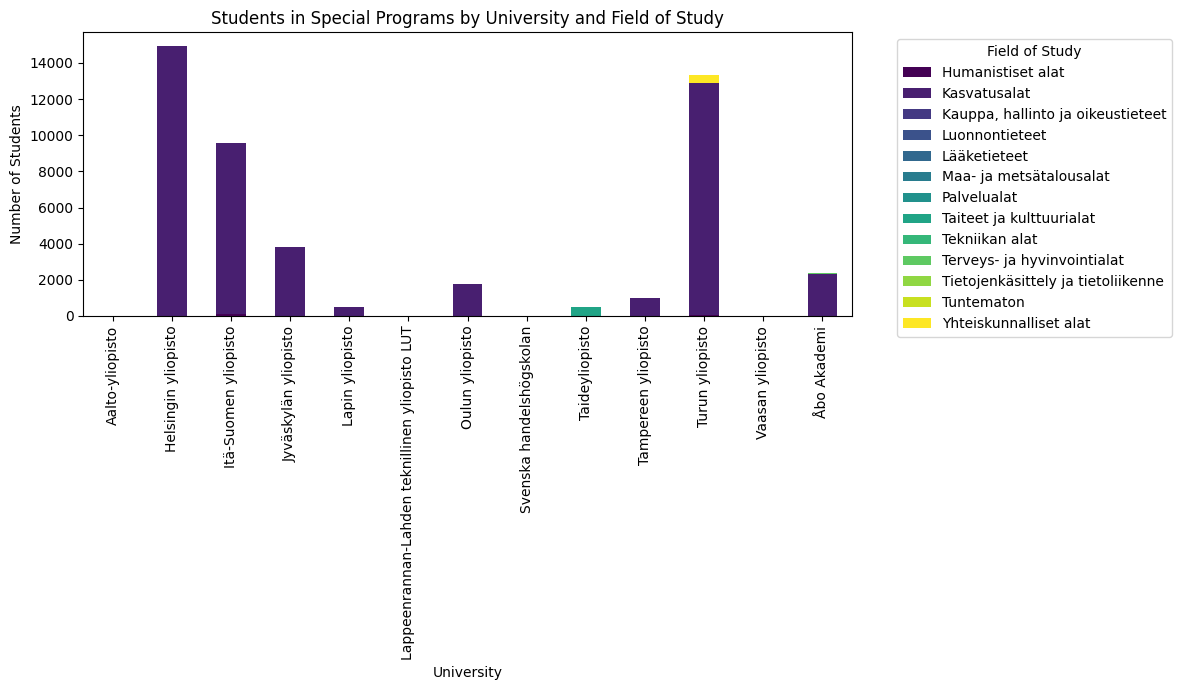

In [24]:
if "erillisillaOikOpkoulOpLkm" in display_data.columns and "yliopisto" in display_data.columns and "okmOhjauksenAla" in display_data.columns:
    df_stacked = display_data.groupby(["yliopisto", "okmOhjauksenAla"])["erillisillaOikOpkoulOpLkm"].sum().unstack().fillna(0)

    df_stacked.plot(kind="bar", stacked=True, figsize=(12, 7), colormap="viridis")
    plt.title("Students in Special Programs by University and Field of Study")
    plt.xlabel("University")
    plt.ylabel("Number of Students")
    plt.legend(title="Field of Study", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()